<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW5/HW5_Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best parameters for linear: {'alpha': 0.001, 'kernel': 'linear'}
Best mse for linear: 0.3612


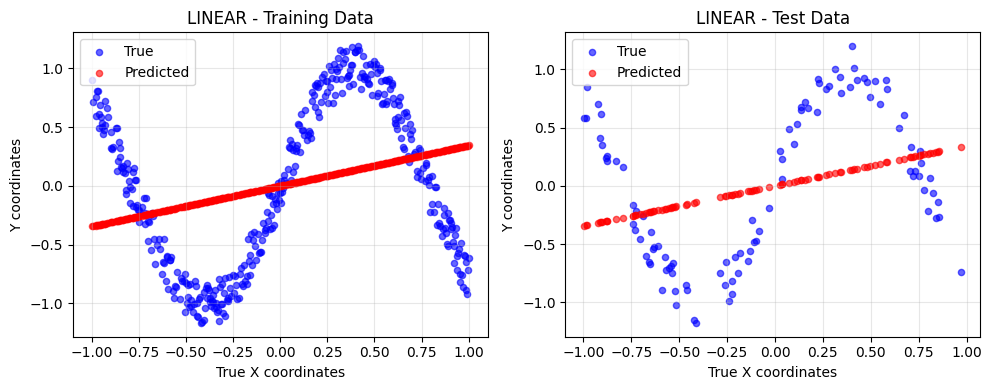

Best parameters for poly: {'alpha': 0.01, 'gamma': 0.4, 'degree': 3, 'coef0': 0.1, 'kernel': 'poly'}
Best mse for poly: 0.0472


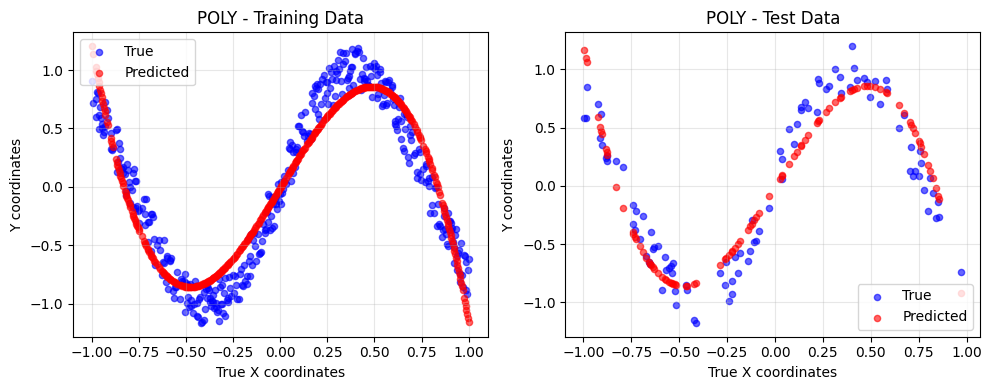

Best parameters for rbf: {'alpha': 0.2, 'gamma': 2.0, 'kernel': 'rbf'}
Best mse for rbf: 0.0151


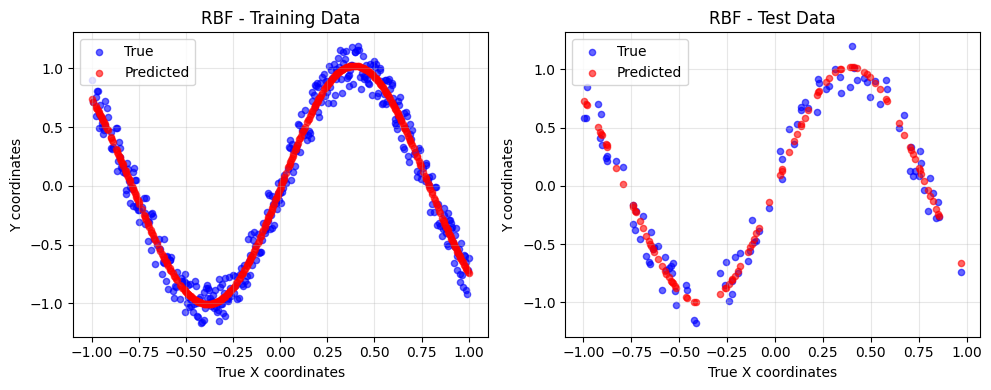

Best parameters for linear: {'alpha': 0.9, 'kernel': 'linear'}
Best mse for linear: 0.5071


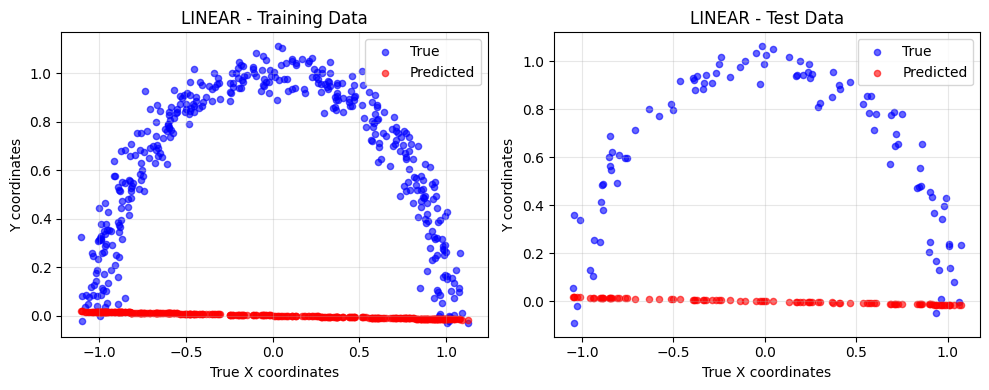

Best parameters for poly: {'alpha': 0.05, 'gamma': 0.8, 'degree': 4, 'coef0': 0.4, 'kernel': 'poly'}
Best mse for poly: 0.0104


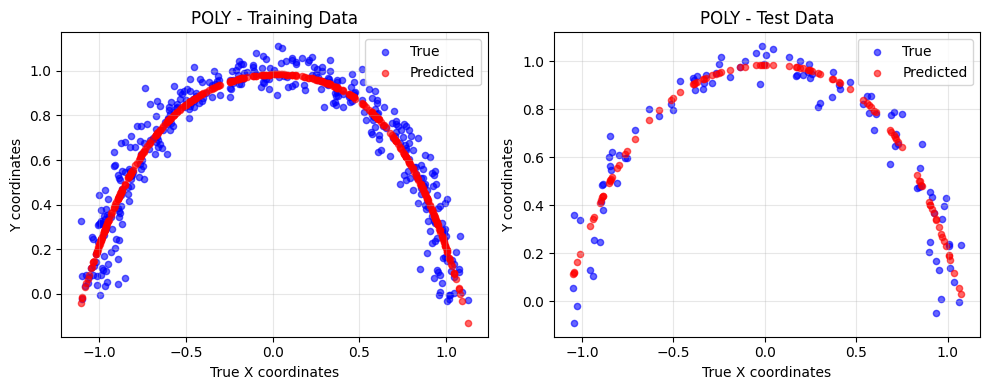

Best parameters for rbf: {'alpha': 0.001, 'gamma': 2.0, 'kernel': 'rbf'}
Best mse for rbf: 0.0101


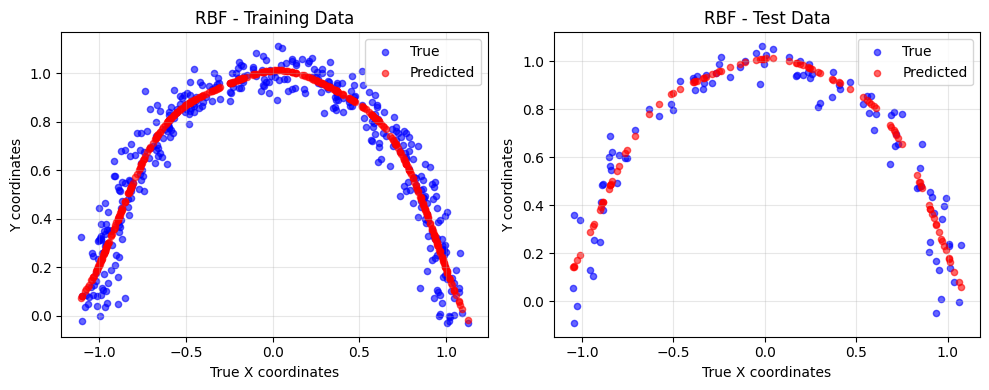

In [13]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt

class KernelRidgeRegression:
    def __init__(self, kernel, alpha=1.0, gamma=1.0, degree=3, coef0=1.0):
        """
        Initialize the Kernel Ridge Regression model.

        Params:
        ---------
        kernel:
            types of kernel: 'linear', 'poly', 'rbf'
        alpha:
            regularization parameter
        gamma:
            kernel coefficient for 'rbf' and 'poly' kernel
        degree:
            degree of the 'poly' kernel
        coef0:
            bias term for 'poly' kernel
        """
        self.kernel = kernel
        self.alpha = alpha
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0

    def _calculate_kernel(self, X1, X2):
        if self.kernel == 'linear':
            return linear_kernel(X1, X2)
        elif self.kernel == 'poly':
            return polynomial_kernel(X1, X2, degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        elif self.kernel == 'rbf':
            return rbf_kernel(X1, X2, gamma=self.gamma)
        else:
            raise ValueError("Invalid kernel type")

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

        # Apply kernel
        kernel = self._calculate_kernel(X, X)
        # Apply regularization
        regularized_kernel = kernel + self.alpha * np.eye(kernel.shape[0])
        self.alpha_coef = np.linalg.inv(regularized_kernel) @ y

    def predict(self, X):
        kernel = self._calculate_kernel(X, self.X_train)
        return kernel @ self.alpha_coef


def fetch_data():
    wave_x_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/waveX.txt"
    wave_y_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/waveY.txt"
    crescent_x_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/crescentX.txt"
    crescent_y_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/crescentY.txt"

    wave_x_data = pd.read_csv(wave_x_url, header=None).values
    wave_y_data = pd.read_csv(wave_y_url, header=None).values

    wave_X = wave_x_data.reshape(-1, 1)
    wave_y = wave_y_data.ravel()

    crescent_x = pd.read_csv(crescent_x_url, header=None).values
    crescent_y = pd.read_csv(crescent_y_url, header=None).values

    crescent_X = crescent_x.reshape(-1, 1)
    crescent_y = crescent_y.ravel()

    return wave_X, wave_y, crescent_X, crescent_y

def split_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test


def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    kernel_types = ['linear', 'poly', 'rbf']
    for kernel_type in kernel_types:
        params, mse = hyperparameter_tuning(X_train, y_train, X_test, y_test, kernel_type)

        print(f"Best parameters for {kernel_type}: {params}")
        print(f"Best mse for {kernel_type}: {mse:.4f}")

        model = KernelRidgeRegression(**params)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        plot_wave_results(X_train, y_train, X_test, y_test, {'kernel_name': kernel_type, 'y_pred_train': y_train_pred, 'y_pred_test': y_test_pred})



def hyperparameter_tuning(X_train, y_train, X_test, y_test, kernel_type):
    if kernel_type == 'linear':
        param_grid = {
            'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        }
    elif kernel_type == 'poly':
        param_grid = {
            'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7],
            'gamma': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            'degree': [2, 3, 4],
            'coef0': [0.1, 0.2, 0.3, 0.4, 0.5]
        }
    elif kernel_type == 'rbf':
        param_grid = {
            'alpha': [0.001, 0.01, 0.05, 0.1, 0.2],
            'gamma': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
        }
    else:
        raise ValueError("Invalid kernel type")

    best_params = None
    best_mse = np.inf

    from itertools import product

    for param_combination in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), param_combination))
        params['kernel'] = kernel_type

        model = KernelRidgeRegression(**params)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_test_pred)

        if mse < best_mse:
            best_mse = mse
            best_params = params

    return best_params, best_mse

def plot_wave_results(X_train, y_train, X_test, y_test, result):
    plt.figure(figsize=(10, 4))

    # Plot 1: Training data
    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:, 0], y_train, color='blue', label='True', alpha=0.6, s=20)
    plt.scatter(X_train[:, 0], result['y_pred_train'], color='red', label='Predicted', alpha=0.6, s=20)

    plt.xlabel('True X coordinates')
    plt.ylabel('Y coordinates')
    plt.title(f'{result["kernel_name"].upper()} - Training Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Test data
    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], y_test, color='blue', label='True', alpha=0.6, s=20)
    plt.scatter(X_test[:, 0], result['y_pred_test'], color='red', label='Predicted', alpha=0.6, s=20)

    plt.xlabel('True X coordinates')
    plt.ylabel('Y coordinates')
    plt.title(f'{result["kernel_name"].upper()} - Test Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    wave_X, wave_y, crescent_X, crescent_y = fetch_data()

    wave_X_train, wave_X_test, wave_y_train, wave_y_test = split_data(wave_X, wave_y)
    train_and_evaluate_model(wave_X_train, wave_y_train, wave_X_test, wave_y_test)

    crescent_X_train, crescent_X_test, crescent_y_train, crescent_y_test = split_data(crescent_X, crescent_y)
    train_and_evaluate_model(crescent_X_train, crescent_y_train, crescent_X_test, crescent_y_test)





Linear kernel fails to predict such non-linear data.  
Poly kernel is good at capturing curvilinear relationships although it appears some bias.  
Rbf kernel behave the best on both data. However it seems easily to be overfitting as showing on crescent data the curve is not smooth.

